In [1]:
"""\
# Copyright (C) 2024 Jesús Bautista Villar <jesbauti20@gmail.com>
- Source seeking simulations (distributed computing) -
"""
!python -V || python3 -V

Python 3.10.12


In [6]:
# If executed from Google Colab --------------------------------------------------------
# !git clone https://github.com/jesusBV20/source_seeking_distr.git
# !rsync -a source_seeking_distr/ .
# !rm -r source_seeking_distr

# If you want to use latex with matplotlib ---------------------------------------------
# !apt install -y texlive texlive-latex-extra texlive-fonts-recommended dvipng cm-super
# !pip install -y latex

In [9]:
import numpy as np
import os
import random
import sys
from tqdm import tqdm

# Graphic tools
from IPython.display import HTML
from matplotlib.animation import PillowWriter

# --------------------------------------------------------------------------------------

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Scalar field functions
from sourceseeking_distr.scalar_field.sigma_common import SigmaField
from sourceseeking_distr.scalar_field.sigma_funcs import SigmaGauss, SigmaNonconvex, SigmaFract 

# Simulators
from sourceseeking_distr.simulator.sim_singint import SingIntSimulator
from sourceseeking_distr.simulator.sim_unicycle import UnicycleSimulator

from sourceseeking_distr.plotter.plt_singint import SingIntPlotter
from sourceseeking_distr.plotter.plt_unicycle import UnicyclePlotter

# Main utility functions used along the notebook
from sourceseeking_distr.toolbox.math_utils import XY_distrib, gen_random_graph, gen_Z_split
from sourceseeking_distr.toolbox.basic_utils import createDir

# --------------------------------------------------------------------------------------

# Create the output directory
OUTPUT_FOLDER = os.path.join("..", "output")
createDir(OUTPUT_FOLDER)

The directory '..\output' already exists!


## Single integrator dynamics

### Maneuvering, split in $n$ teams, and dead units

In [10]:
## Parameters #####
pc = np.array([-45,-50])
N = 250

p = XY_distrib(N, pc, np.array([2,7]))
p2 = XY_distrib(N, np.array([0,0]), np.array([5,2]))

dist_thr_init = 10
Z = gen_Z_split(N, 1, int(N**1.98))
# len(Z)

q0 = [p, 15]

# ----------------------------------------------------------------------
# Generating the scalar field
# ----------------------------------------------------------------------
n = 2
max_int = 20
mu = [40,40]
# dev = [10,4]
dev = 10

sigma_field = SigmaNonconvex(k=0.04, dev=dev, mu=mu)

In [11]:
# ----------------------------------------------------------------------
# Generating the simulator class
# ----------------------------------------------------------------------
dt = 1/25
tf = 13

sim = SingIntSimulator(q0, Z, sigma_field, dt=dt, kc=0.05, kl=0.05, its_c=4, its_l=7)
sim.ks = 1

# ----------------------------------------------------------------------
# Execute the simulation given a desired final time stamp
# ----------------------------------------------------------------------
t_list = np.arange(0, tf, dt)

t1, t2 = 3, 4
for it in tqdm(range(len(t_list))): 
    if it % int(0.1/dt) == 0 and it != 0:
        sim.kill_agents(random.choice(range(N)))

    if it == int(t1/dt):
        sim.mod_shape = True
        sim.xd = p2
    if it == int(t2/dt):
        sim.mod_shape = False
        sim.set_Z(gen_Z_split(N, 5))

    sim.int_step()

100%|██████████| 325/325 [01:01<00:00,  5.28it/s]


100%|██████████| 15/15 [06:27<00:00, 27.68s/it]


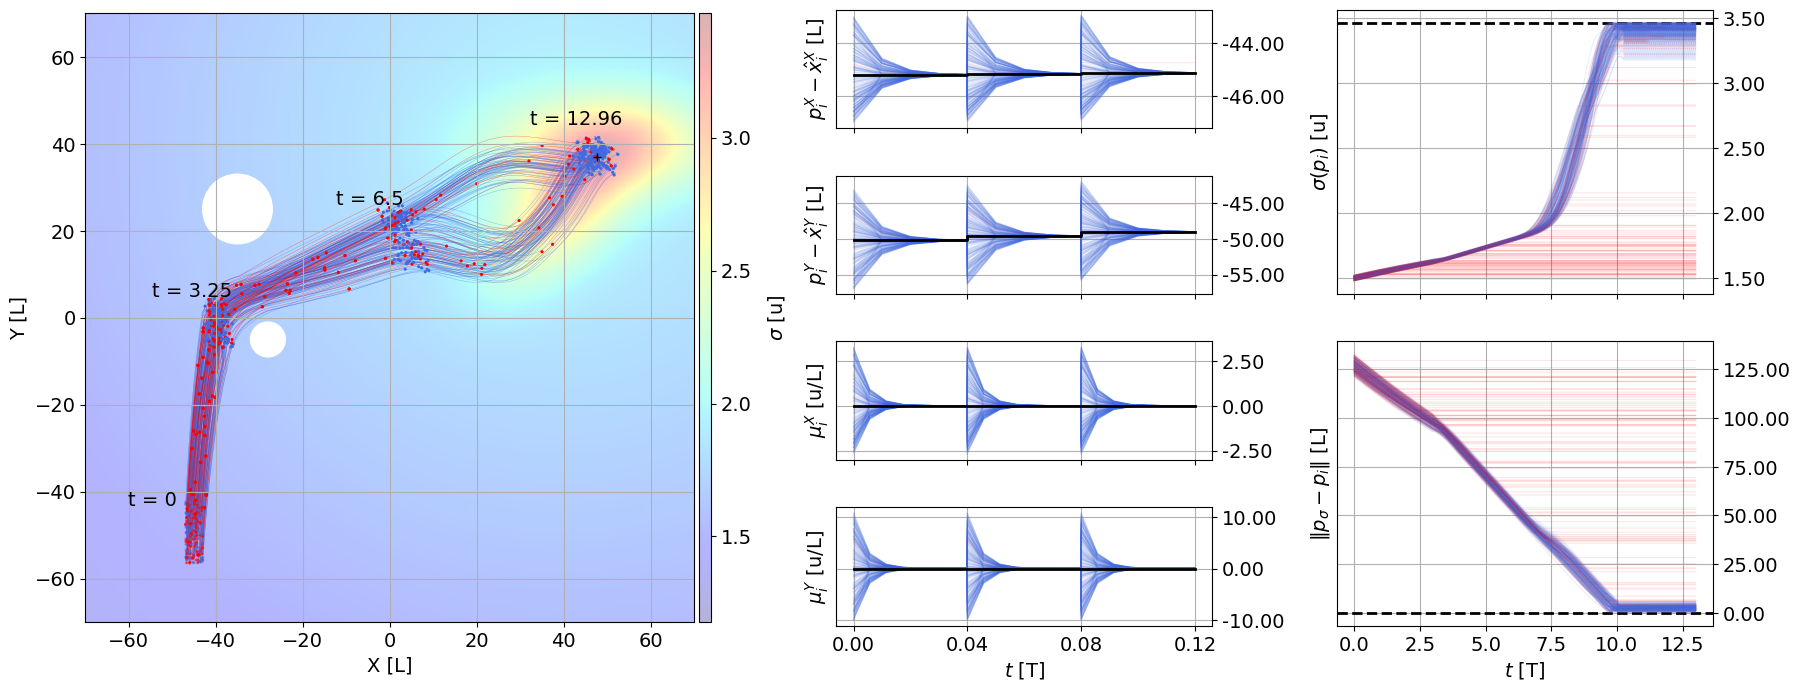

In [12]:
# ----------------------------------------------------------------------
# Plot simulations and estimations
# ----------------------------------------------------------------------

plotter_sim = SingIntPlotter(sim, xlim=[-70,70], ylim=[-70,70], agents_size=0.2, lw=0.3)
# plotter_sim.plot_simulation()
# plotter_sim.plot_estimations()

plotter_sim.plot_paper_fig(
    figsize=(21, 8),
    dpi=100,
    obstacles=[[-35, 25, 8], [-28, -5, 4]],
    est_window=[0, dt * 3],
    alpha=0.1
)

In [13]:
# --------------------------------------------------------------------------------------
# Animation
# --------------------------------------------------------------------------------------
# Set the framerate
fps = 15
dt = 1/fps
tf = 13

# Generate a new numerical simulation with the new dt
sim = SingIntSimulator(q0, Z, sigma_field, dt=dt, kc=0.05, kl=0.05, its_c=4, its_l=7)

# --------------------------------------------------------------------------------------
# Execute the simulation given a desired final time stamp

t_list = np.arange(0, tf, dt)

t1, t2 = 3, 4
for it in tqdm(range(len(t_list))): 
    if it % int(0.1/dt) == 0 and it != 0:
        sim.kill_agents(random.choice(range(N)))

    if it == int(t1/dt):
        sim.mod_shape = True
        sim.xd = p2
    if it == int(t2/dt):
        sim.mod_shape = False
        sim.set_Z(gen_Z_split(N, 5))

    sim.int_step()

# --------------------------------------------------------------------------------------
# Generate the animation 

plotter_sim = SingIntPlotter(sim, xlim=[-70,70], ylim=[-70,70], agents_size=0.2, lw=0.1)

# -- MP4 
anim = plotter_sim.anim_simulation(fps=fps, dpi=80)
HTML(anim.to_html5_video()) # It takes a loooot of time...

# -- GIF
# writer = PillowWriter(fps=fps, bitrate=1800)
# anim.save(os.path.join(OUTPUT_FOLDER, "split.gif"), # It takes a loooot of time...
#         writer = writer)

100%|██████████| 195/195 [00:42<00:00,  4.56it/s]


Generating 195 frames...


100%|██████████| 195/195 [01:58<00:00,  1.59it/s]

## Unicycle dynamics

### Basic example

In [2]:
## Parameters #####
pc = np.array([5,60])
lims = np.array([9,10])

N = 10
p = XY_distrib(N,pc,lims)
phi = np.random.rand(N) * np.pi
Z = gen_random_graph(N, rounds=3)

v = 2

# ----------------------------------------------------------------------
# Generating the scalar field
# ----------------------------------------------------------------------
n = 2
max_int = 20
mu = [40,40]
dev = 10

sigma_field = SigmaNonconvex(k=0.04, dev=dev, mu=mu)

In [3]:
# ----------------------------------------------------------------------
# Generating the simulator class
# ----------------------------------------------------------------------
dt = 1/60
q0 = [p, v, phi]

sim = UnicycleSimulator(q0, Z, sigma_field, dt=dt, kc=0.01, kl=0.3, its_c=5, its_l=10)

# ----------------------------------------------------------------------
# Execute the simulation given a desired final time stamp
# ----------------------------------------------------------------------
tf = 40
its = int(tf/dt)

for it in tqdm(range(its)): 
    sim.int_step()

  0%|          | 0/2400 [00:00<?, ?it/s]

100%|██████████| 2400/2400 [00:01<00:00, 1648.66it/s]


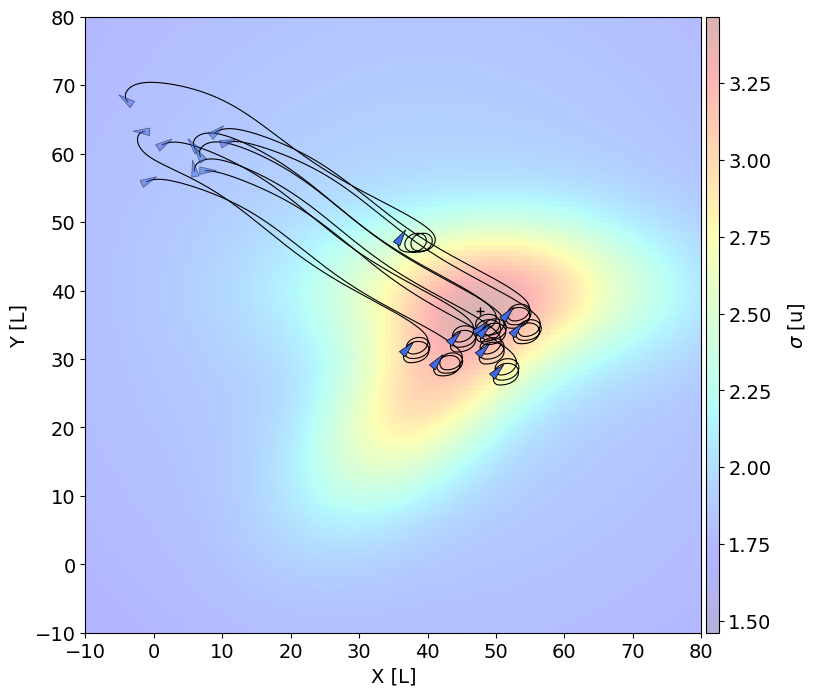

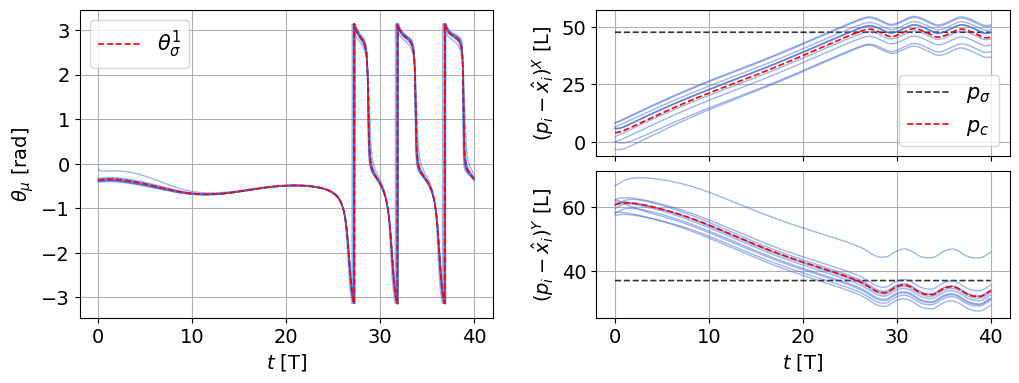

In [4]:
# ----------------------------------------------------------------------
# Plot simulations and estimations
# ----------------------------------------------------------------------
lims=[-10,80]

plotter_sim = UnicyclePlotter(sim, xlim=lims, ylim=lims)
plotter_sim.plot_simulation()
plotter_sim.plot_estimations()

### One team splites in two

In [7]:
## Parameters #####
pc = np.array([-60,-20])
lims = np.array([15,15])

N = 9
p = XY_distrib(N,pc,lims)
phi = np.random.rand(N) * np.pi
Z = [(1,2), (2,3), (3,4), (4,1), 
     (4,5), (5,3), (5,6), (9,5),
     (6,7), (7,8), (8,9), (9,6)]

Z = np.array(Z) - 1

# ----------------------------------------------------------------------
# Generating the scalar field
# ----------------------------------------------------------------------
n = 2
max_int = 20
mu = [40,40]
dev = [10,4]

sigma_field = SigmaNonconvex(k=0.01, dev=dev, mu=mu)

In [8]:
# ----------------------------------------------------------------------
# Generating the simulator class
# ----------------------------------------------------------------------
dt = 1/60
tf = 25
q0 = [p, 15, phi]

sim = UnicycleSimulator(q0, Z, sigma_field, dt=dt, kc=0.1, kl=2, its_c=5, its_l=10)

# ----------------------------------------------------------------------
# Execute the simulation given a desired final time stamp
# ----------------------------------------------------------------------
its = int(tf/dt)

for it in tqdm(range(its)): 
    if it == int(4/dt):
        sim.kill_agents([4])
    sim.int_step()

100%|██████████| 1500/1500 [00:01<00:00, 1117.74it/s]


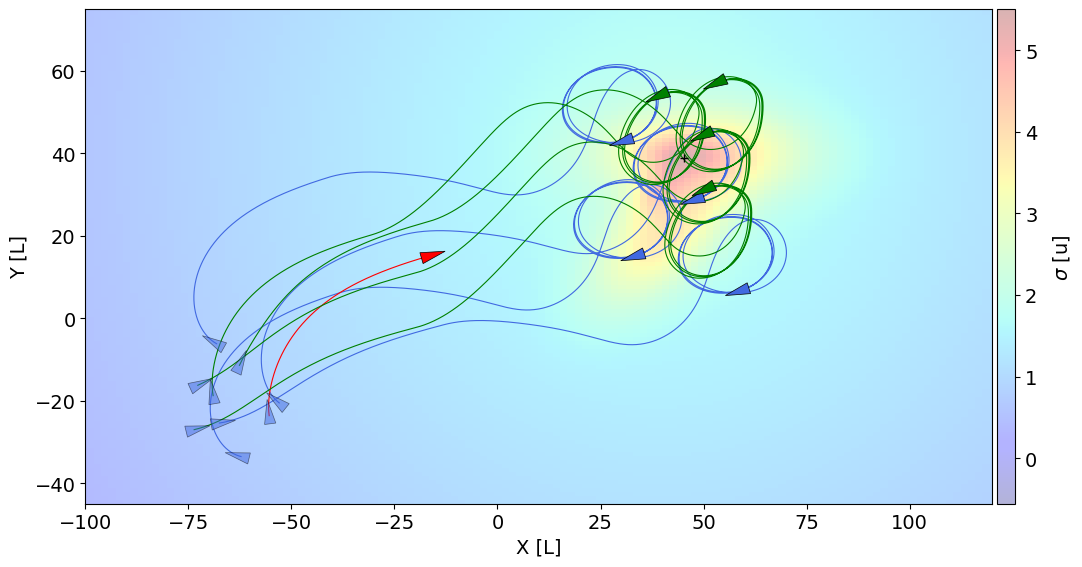

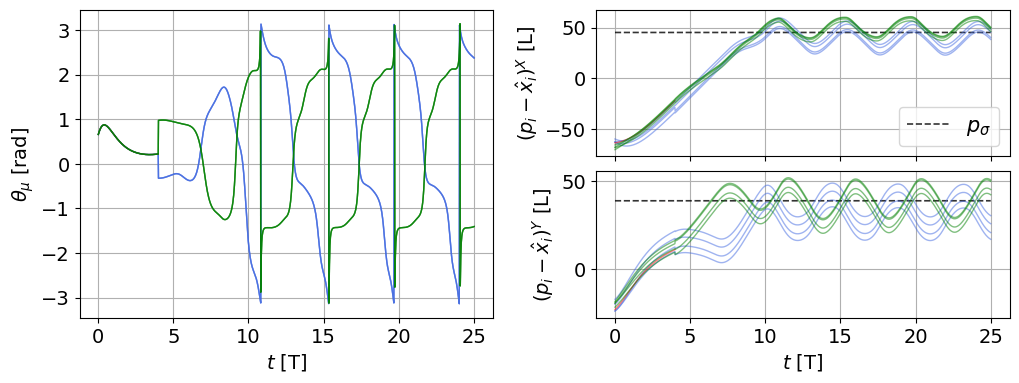

In [ ]:
# ----------------------------------------------------------------------
# Plot simulations and estimations
# ----------------------------------------------------------------------
team_tags = [0,0,0,0,2,1,1,1,1]

plotter_sim = UnicyclePlotter(sim, team_tags=team_tags, xlim=[-100,120], ylim=[-45,75], agents_size=3)
plotter_sim.plot_simulation()
plotter_sim.plot_estimations()

In [ ]:
# ----------------------------------------------------------------------
# Animation
# ----------------------------------------------------------------------
# Set the framerate
fps = 15
dt = 1/fps
tf = 15

# Generate a new numerical simulation with the new dt
sim = UnicycleSimulator(q0, Z, sigma_field, dt=dt, kc=0.1, kl=2, its_c=5, its_l=10)

its = int(tf/dt)
for it in tqdm(range(its)): 
    if it == int(2/dt):
        sim.kill_agents([4])
    sim.int_step()

# Generate the animation
team_tags = [0,0,0,0,2,1,1,1,1]
plotter_sim = UnicyclePlotter(sim, team_tags=team_tags, xlim=[-100,120], ylim=[-45,75], agents_size=3)

# -- MP4 
anim = plotter_sim.anim_simulation(fps=fps, dpi=80)
HTML(anim.to_html5_video()) # It takes a loooot of time...

# -- GIF
# writer = PillowWriter(fps=fps, bitrate=1800)
# anim.save(os.path.join(OUTPUT_FOLDER, "split.gif"), # It takes a loooot of time...
#         writer = writer)

100%|██████████| 225/225 [00:00<00:00, 1145.06it/s]


Generating 225 frames...


100%|█████████▉| 224/225 [00:14<00:00, 15.68it/s]

100%|█████████▉| 224/225 [00:27<00:00, 15.68it/s]